# Customer Churn Prediction 

This notebook contains an end-to-end pipeline for the Customer Churn Prediction project.

**Before running:** download `WA_Fn-UseC_-Telco-Customer-Churn.csv` from Kaggle and place it in this folder.


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import (accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve)
import warnings
warnings.filterwarnings('ignore')


In [ ]:
DATA_FILENAME = 'WA_Fn-UseC_-Telco-Customer-Churn.csv'
df = pd.read_csv(DATA_FILENAME)
print('Shape:', df.shape)
df.head()


Shape: (7043, 21)


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [6]:
df.info()
print('\nMissing values per column:')
print(df.isnull().sum())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [7]:
if 'customerID' in df.columns:
    df.drop('customerID', axis=1, inplace=True)
if 'TotalCharges' in df.columns:
    df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
    df['TotalCharges'].fillna(df['TotalCharges'].median(), inplace=True)
print('After cleaning, missing values:')
print(df.isnull().sum())


After cleaning, missing values:
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64


In [8]:
cat_cols = df.select_dtypes(include='object').columns.tolist()
le = LabelEncoder()
for c in cat_cols:
    df[c] = le.fit_transform(df[c].astype(str))
df.head()


,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,0,0,1,0,1,0,1,0,0,2,0,0,0,0,0,1,2,29.85,29.85,0
1,1,0,0,0,34,1,0,0,2,0,2,0,0,0,1,0,3,56.95,1889.50,0
2,1,0,0,0,2,1,0,0,2,2,0,0,0,0,0,1,3,53.85,108.15,1
3,1,0,0,0,45,0,1,0,2,0,2,2,0,0,1,0,0,42.30,1840.75,0
4,0,0,0,0,2,1,0,1,0,0,0,0,0,0,0,1,2,70.70,151.65,1


In [9]:
X = df.drop('Churn', axis=1)
y = df['Churn']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
print('Train shape:', X_train.shape, 'Test shape:', X_test.shape)


Train shape: (5634, 19) Test shape: (1409, 19)


In [10]:
models = {
    'Logistic': LogisticRegression(max_iter=1000),
    'RandomForest': RandomForestClassifier(n_estimators=200, random_state=42),
    'GradientBoosting': GradientBoostingClassifier(n_estimators=200, learning_rate=0.1, random_state=42)
}
results = {}
for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    y_prob = model.predict_proba(X_test_scaled)[:,1]
    results[name] = {
        'accuracy': accuracy_score(y_test, y_pred),
        'roc_auc': roc_auc_score(y_test, y_prob),
        'report': classification_report(y_test, y_pred, output_dict=True)
    }
    print(f"{name} -> Accuracy: {results[name]['accuracy']:.4f}, ROC-AUC: {results[name]['roc_auc']:.4f}")


Logistic -> Accuracy: 0.7991, ROC-AUC: 0.8403
RandomForest -> Accuracy: 0.7878, ROC-AUC: 0.8247
GradientBoosting -> Accuracy: 0.8062, ROC-AUC: 0.8411


In [ ]:
best_model = RandomForestClassifier(n_estimators=200, random_state=42)
best_model.fit(X_train_scaled, y_train)
y_pred_best = best_model.predict(X_test_scaled)
print('Best model accuracy:', accuracy_score(y_test, y_pred_best))
joblib.dump(best_model, 'churn_model.pkl')
joblib.dump(scaler, 'scaler.pkl')
print('Saved churn_model.pkl and scaler.pkl in current folder')


Best model accuracy: 0.7877927608232789
Saved churn_model.pkl and scaler.pkl in current folder


TotalCharges        0.188114
MonthlyCharges      0.178972
tenure              0.157034
Contract            0.076977
PaymentMethod       0.050554
OnlineSecurity      0.050154
TechSupport         0.041208
gender              0.027901
InternetService     0.027594
OnlineBackup        0.026865
PaperlessBilling    0.026372
MultipleLines       0.023646
Partner             0.022734
DeviceProtection    0.021659
SeniorCitizen       0.020977
dtype: float64


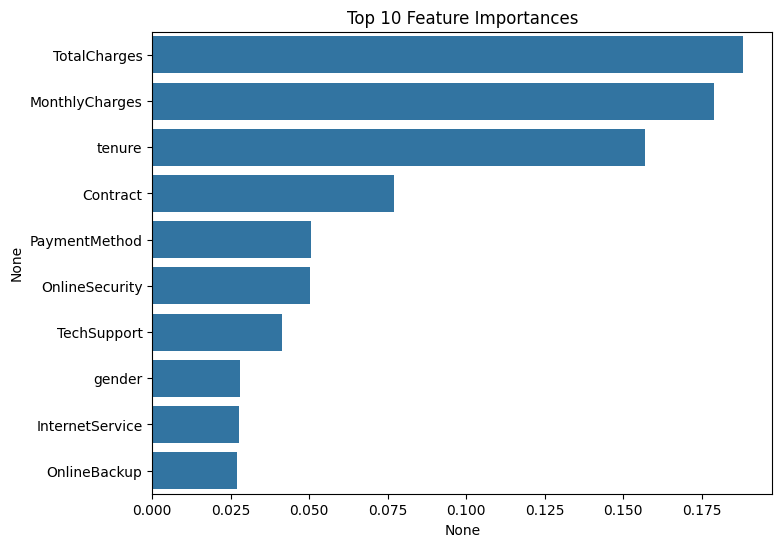

In [12]:
importances = best_model.feature_importances_
feat_names = X.columns
feat_imp = pd.Series(importances, index=feat_names).sort_values(ascending=False)
print(feat_imp.head(15))
plt.figure(figsize=(8,6))
sns.barplot(x=feat_imp.head(10), y=feat_imp.head(10).index)
plt.title('Top 10 Feature Importances')
plt.show()
